 **Assignment 1: *BONUS* part1**

Name: Amr Abdelsamee Youssef &emsp; ID: 7126

Name: Hazem Mohamed Abdallah &ensp; ID: 6723

Name: Ahmed Ashraf Abdelkarim &emsp; ID: 6940

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
faces_path = "/content/drive/MyDrive/Colab Notebooks/Pattern/projects/data/faces"

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle


from pylab import rcParams

## Loading The Data

In [ ]:
ROWS = 400
COLS = 10304

#initiating vectors
data = [[0 for i in range(COLS)] for i in range(ROWS)]
labels = [0 for i in range(ROWS)]

for i in range(40):
    j=0
    for j in range (10):
        img = Image.open( faces_path +'/s' + str(i+1)+'/'+str(j+1)+'.pgm' )

        # convert it to a matrix (vector)
        data[i*10+j] = np.matrix(np.array(img).ravel())
        
        #IDS Classes
        labels[i*10+j]=i+1

In [ ]:
orig_labels = np.array(labels)
orig_data = np.array(data)
data, labels = shuffle(orig_data, orig_labels)

### Split The Data

In [ ]:
data_train = data.copy()[0:280,:].reshape(280, COLS)
data_test = data.copy()[280:,:].reshape(120, COLS)
labels_train = labels.copy()[0:280]
labels_test = labels.copy()[280:]
print("training data:", data_train.shape, " :: training labels:",labels_train.shape)
print("testing data:", data_test.shape, " :: testing labels:",labels_test.shape)

training data: (280, 10304)  :: training labels: (280,)
testing data: (120, 10304)  :: testing labels: (120,)


## PCA

In [ ]:
def get_Dim(eigen_values, alpha):
    total_variance = np.sum(eigen_values)
    fraction_variance = 0
    eigen_values_sum = 0
    r = 0
    while(fraction_variance < alpha):
        eigen_values_sum += eigen_values[r]
        fraction_variance = eigen_values_sum / total_variance
        r+=1
    return r

In [ ]:
def PCA(train, test, alphas):
  # compute the mean
  mean = np.mean(train, axis = 0)

  # center the data
  Z = train - mean

  # get the covariance matrix
  cov = np.cov(Z, rowvar=False, bias=True)

  # get the eigenvalues and eigenvectors
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  # get the needed dimension for each alpha
  alphas_dim = []
  for alpha in alphas:
      alphas_dim.append(get_Dim(np.flip(eigen_values, axis=0), alpha))

  print("alphas_dim :",alphas_dim)

  Z_test = test - mean

  eigen_vectors = np.flip(eigen_vectors, axis=1)

  proj_mats = []
  reduced_data_train = []
  reduced_data_test = []
  for i in range(0, len(alphas_dim)):
    proj_mats.append(eigen_vectors[:,0:alphas_dim[i]])
    reduced_data_train.append(np.matmul(proj_mats[i].transpose(), Z.transpose()))
    reduced_data_test.append(np.matmul(proj_mats[i].transpose(), Z_test.transpose()))
    print("proj_mat"+str(i)+":", proj_mats[i].shape)
    print("Reduced_data_train"+str(i)+":", reduced_data_train[i].shape)
    print("Reduced_data_test"+str(i)+":", reduced_data_test[i].shape)

  return {
      "centered_data":Z,
      "eigen_values":eigen_values,
      "eigen_vectors": eigen_vectors,
      "alphas_dim":alphas_dim,
      "proj_matrix": proj_mats,
      "reduced_data_train": reduced_data_train,
      "reduced_data_test": reduced_data_test
  }

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
pca = PCA(data_train, data_test, alphas)

alphas_dim : [40, 60, 92, 148]
proj_mat0: (10304, 40)
Reduced_data_train0: (40, 280)
Reduced_data_test0: (40, 120)
proj_mat1: (10304, 60)
Reduced_data_train1: (60, 280)
Reduced_data_test1: (60, 120)
proj_mat2: (10304, 92)
Reduced_data_train2: (92, 280)
Reduced_data_test2: (92, 120)
proj_mat3: (10304, 148)
Reduced_data_train3: (148, 280)
Reduced_data_test3: (148, 120)


In [ ]:
# print("pca.centered_data ",pca["centered_data"])
# print("pca.eigen_values ",pca["eigen_values"])
# print("pca.eigen_vectors ",pca["eigen_vectors"])
# print("pca.alphas_dim ",pca["alphas_dim"])
# print("pca.proj_matrix ",pca["proj_matrix"])
# print("pca.reduced_data_train ",pca["reduced_data_train"])
# print("pca.reduced_data_test ",pca["reduced_data_test"])

### Faces plots:

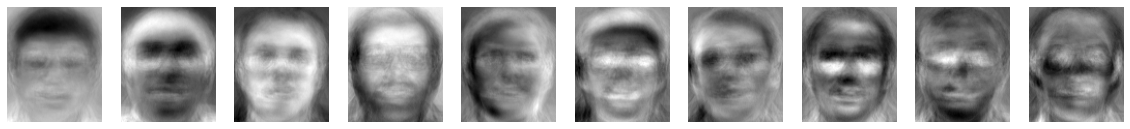

In [ ]:
#displaying the first 10 eigen vectors as images.(i.e. eigen face)

plt.rcParams["figure.figsize"] = [20.00, 5]

for i in range(0, 10):
    eigen_face = pca["eigen_vectors"][:,i].reshape(112,92)
    plt.subplot(1, 10, i+1)
    plt.imshow(eigen_face, cmap='gray');
    plt.axis('off')
plt.show()

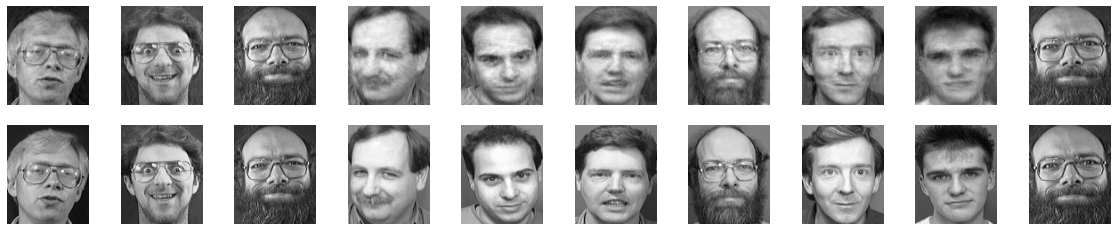

In [ ]:
# An example of a reconstructed image from the reduced data and the projection matrix (when alph = 0.95)
# to compare the reconstructed face and the original face. 
plt.rcParams["figure.figsize"] = [20.00, 4]
fig, axs = plt.subplots(2, 10)

# reconstruction
re_faces = np.matmul(pca["reduced_data_train"][-1].T, pca["proj_matrix"][-1].T ) + np.mean(data_train, axis = 0)

for i in range(0, 50, 5):
    axs[0, i//5].imshow(re_faces[i].reshape(112,92), cmap='gray');
    axs[0, i//5].axis('off')
    axs[1, i//5].imshow(data_train[i].reshape(112,92), cmap='gray');
    axs[1, i//5].axis('off')
plt.show()

## KNN - PCA

In [ ]:
def KNNPCA(data, proj_mat, numberOfNeighors):
    knn_pca = KNeighborsClassifier(n_neighbors = numberOfNeighors)
    knn_pca.fit(data.T, labels_train)
    mean = np.mean(data_test, axis=0)
    Z2 = data_test - mean
    newTestData = np.matmul(Z2, proj_mat)
    predicted_data = knn_pca.predict(newTestData)
    accuracy = metrics.accuracy_score(labels_test, predicted_data)
    return accuracy

In [ ]:
KNNS = [1, 3, 5, 7]

accuracy_KNN1 = []
accuracy_KNN3 = []
accuracy_KNN5 = []
accuracy_KNN7 = []

for i in range(len(KNNS)):
    accuracy_KNN1.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[0]))
    accuracy_KNN3.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[1]))
    accuracy_KNN5.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[2]))
    accuracy_KNN7.append(KNNPCA(pca["reduced_data_train"][i], pca["proj_matrix"][i], KNNS[3]))

for i in range(len(KNNS)):
    print("alpha: ", alphas[i])
    print("KNN1:",accuracy_KNN1[i])    
    print("KNN3:",accuracy_KNN3[i])
    print("KNN5:",accuracy_KNN5[i])
    print("KNN7:",accuracy_KNN7[i])
    print("---------------------------------------")

alpha:  0.8
KNN1: 0.9583333333333334
KNN3: 0.9166666666666666
KNN5: 0.8916666666666667
KNN7: 0.7833333333333333
---------------------------------------
alpha:  0.85
KNN1: 0.9666666666666667
KNN3: 0.9333333333333333
KNN5: 0.8833333333333333
KNN7: 0.8166666666666667
---------------------------------------
alpha:  0.9
KNN1: 0.9666666666666667
KNN3: 0.9166666666666666
KNN5: 0.8833333333333333
KNN7: 0.8083333333333333
---------------------------------------
alpha:  0.95
KNN1: 0.9666666666666667
KNN3: 0.925
KNN5: 0.8666666666666667
KNN7: 0.7916666666666666
---------------------------------------


### Plotting Alphas againist Accuracy:

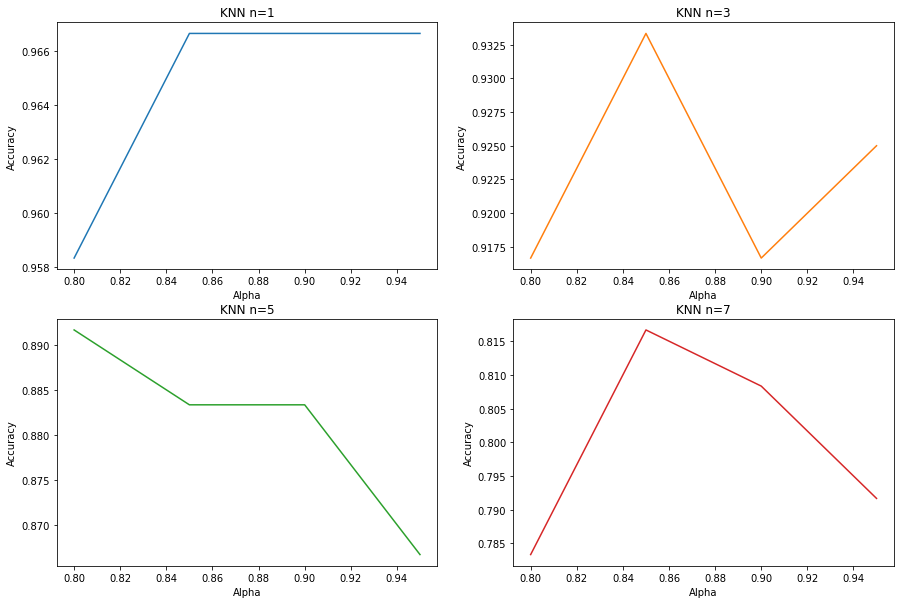

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [15, 10]

axs[0, 0].plot(alphas, accuracy_KNN1)
axs[0, 0].set_title('KNN n=1')

axs[0, 1].plot(alphas, accuracy_KNN3, 'tab:orange')
axs[0, 1].set_title('KNN n=3')

axs[1, 0].plot(alphas, accuracy_KNN5, 'tab:green')
axs[1, 0].set_title('KNN n=5')

axs[1, 1].plot(alphas, accuracy_KNN7, 'tab:red')
axs[1, 1].set_title('KNN n=7')

for ax in axs.flat:
    ax.set(xlabel='Alpha', ylabel='Accuracy')

### Plotting KNN Againist Accuracy:

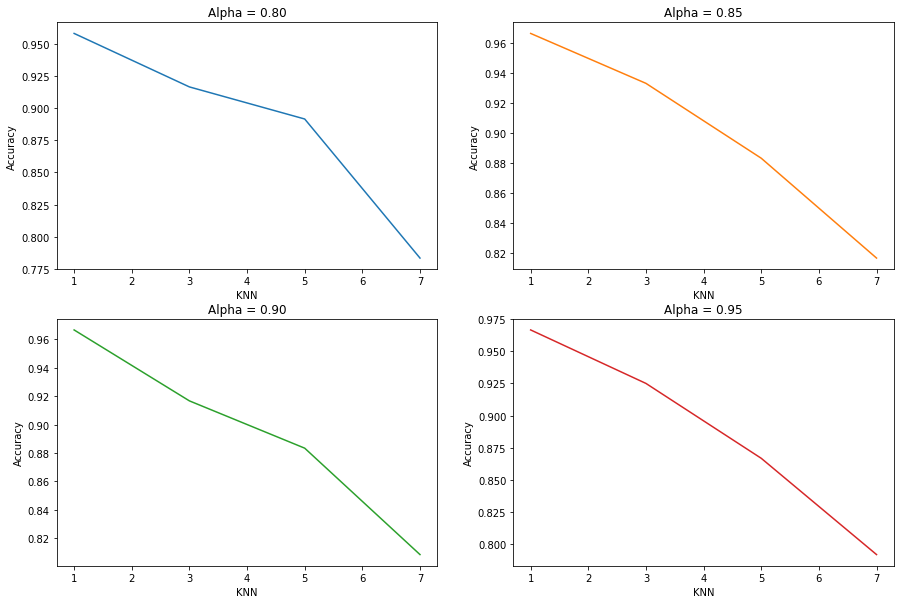

In [ ]:
fig, axs = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [15, 10]

axs[0, 0].plot(KNNS, [ accuracy_KNN1[0], accuracy_KNN3[0], accuracy_KNN5[0], accuracy_KNN7[0]])
axs[0, 0].set_title('Alpha = 0.80')

axs[0, 1].plot(KNNS, [ accuracy_KNN1[1], accuracy_KNN3[1], accuracy_KNN5[1], accuracy_KNN7[1]], 'tab:orange')
axs[0, 1].set_title('Alpha = 0.85')

axs[1, 0].plot(KNNS, [ accuracy_KNN1[2], accuracy_KNN3[2], accuracy_KNN5[2], accuracy_KNN7[2]], 'tab:green')
axs[1, 0].set_title('Alpha = 0.90')

axs[1, 1].plot(KNNS, [ accuracy_KNN1[3], accuracy_KNN3[3], accuracy_KNN5[3], accuracy_KNN7[3]], 'tab:red')
axs[1, 1].set_title('Alpha = 0.95')

for ax in axs.flat:
    ax.set(xlabel='KNN', ylabel='Accuracy')

## LDA

In [ ]:
# mean per class
classified_data = np.split(data_train, 40)
mean_per_class = np.mean(classified_data , axis=1)
print(mean_per_class.shape)

(40, 10304)


In [ ]:
# Within class matrix
S = np.zeros((COLS, COLS))
for i in range(0, 40):
    S += np.dot((classified_data[i] - mean_per_class[i]).T,(classified_data[i] - mean_per_class[i]))
S_inv = np.linalg.inv(S)
print("S shape:", S.shape)
print("S inv shape:", S_inv.shape)

S shape: (10304, 10304)
S inv shape: (10304, 10304)


In [ ]:
# Overall mean of classes
total_mean = np.mean(data_train ,axis=0)
print(total_mean.shape)

(10304,)


In [ ]:
# Between class matrix
B = np.zeros((COLS, COLS))
for i in range(40):
  B += 5 * np.dot( (mean_per_class[i] - total_mean).T , (mean_per_class[i] - total_mean) )
print(B.shape)

(10304, 10304)


In [ ]:
mat = np.dot(B,S_inv)
eig_values_LDA, eig_vectors_LDA = np.linalg.eigh(mat)
print(eig_vectors_LDA.shape)

(10304, 10304)


In [ ]:
# Limiting to 39 dimensions
idx = eig_values_LDA.argsort()[-39:][::-1]
sortedEigVectMatrixLDA = np.real(eig_vectors_LDA[:,idx])

In [ ]:
new_train_data = np.dot(data_train, sortedEigVectMatrixLDA)
new_test_data = np.dot(data_test, sortedEigVectMatrixLDA)

## KNN - LDA


In [ ]:
def KNNLDA(new_train_data, numberOfNeighors):
    knn_lda = KNeighborsClassifier(n_neighbors=numberOfNeighors)
    knn_lda.fit(new_train_data,labels_train)
    predicted_data = knn_lda.predict(new_test_data)
    accuracy = metrics.accuracy_score(labels_test, predicted_data)
    return accuracy

In [ ]:
LDA_accuracy = []
for i in range(len(KNNS)):
    score = KNNLDA(new_train_data, KNNS[i])
    LDA_accuracy.append(score)
    print("KNN: ", KNNS[i],"Accuracy: ",score)


KNN:  1 Accuracy:  0.9666666666666667
KNN:  3 Accuracy:  0.9166666666666666
KNN:  5 Accuracy:  0.8083333333333333
KNN:  7 Accuracy:  0.75


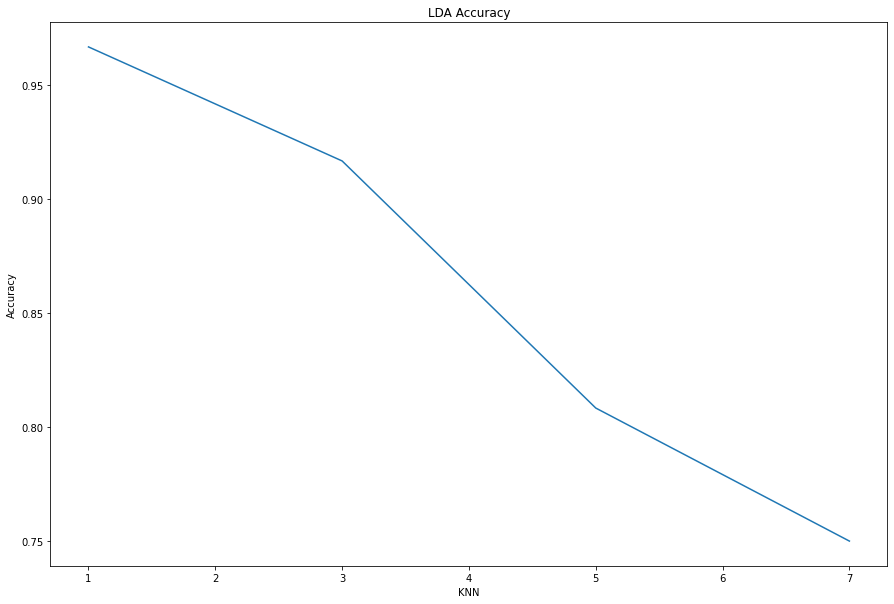

In [ ]:
plt.plot(KNNS, LDA_accuracy)
plt.xlabel('KNN')
plt.ylabel('Accuracy')
plt.title('LDA Accuracy')
plt.show()